In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, auc
import joblib # For saving the model
import pickle # For saving the model

In [2]:
df = pd.read_csv('ecommerce_recommendation_dataset.csv')
df.head()

,user_id,product_id,category,price,rating,review_count,user_age,user_gender,user_location,purchase_history,...,product_rating_variance,review_sentiment_score,user_engagement_score,ad_click_rate,time_of_day,day_of_week,season,payment_method,coupon_used,product_popularity
0,78517,1645,Books,842.23,2,155,24,Other,Urban,False,...,0.13,-0.28,0.68,0.04,Night,Thursday,Summer,Debit Card,False,0.54
1,52887,100,Books,253.76,3,331,43,Other,Suburban,False,...,0.02,0.28,0.11,0.89,Morning,Saturday,Summer,Debit Card,False,0.77
2,59395,585,Books,483.65,2,236,64,Female,Rural,True,...,1.55,0.23,0.35,0.99,Evening,Tuesday,Fall,Debit Card,False,0.14
3,54739,3774,Groceries,459.37,2,227,34,Female,Urban,False,...,1.41,0.93,0.73,0.16,Afternoon,Tuesday,Spring,Credit Card,False,0.18
4,42723,2119,Groceries,150.11,2,214,51,Female,Urban,True,...,1.29,0.11,0.26,0.17,Night,Wednesday,Spring,PayPal,False,0.66


In [3]:
df.columns

Index(['user_id', 'product_id', 'category', 'price', 'rating', 'review_count',
       'user_age', 'user_gender', 'user_location', 'purchase_history',
       'time_on_page', 'add_to_cart_count', 'search_keywords',
       'discount_applied', 'user_membership', 'user_browser', 'user_device',
       'purchase_time', 'session_duration', 'clicks_on_ads', 'page_views',
       'referral_source', 'wishlist_additions', 'cart_abandonment_rate',
       'average_spent', 'user_income', 'user_education', 'user_marital_status',
       'product_availability', 'stock_status', 'product_return_rate',
       'product_color', 'product_size', 'is_top_seller', 'discount_percentage',
       'time_to_purchase', 'delivery_time', 'shipping_fee', 'seller_rating',
       'seller_response_time', 'seller_location', 'product_rating_variance',
       'review_sentiment_score', 'user_engagement_score', 'ad_click_rate',
       'time_of_day', 'day_of_week', 'season', 'payment_method', 'coupon_used',
       'product_popular

In [4]:
df.shape

(60000, 51)

In [5]:
# check misiing values
df.isnull().sum().sum()

0

In [6]:
# check duplicated data
df.duplicated().sum()

0

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 51 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  60000 non-null  int64  
 1   product_id               60000 non-null  int64  
 2   category                 60000 non-null  object 
 3   price                    60000 non-null  float64
 4   rating                   60000 non-null  int64  
 5   review_count             60000 non-null  int64  
 6   user_age                 60000 non-null  int64  
 7   user_gender              60000 non-null  object 
 8   user_location            60000 non-null  object 
 9   purchase_history         60000 non-null  bool   
 10  time_on_page             60000 non-null  float64
 11  add_to_cart_count        60000 non-null  int64  
 12  search_keywords          60000 non-null  object 
 13  discount_applied         60000 non-null  bool   
 14  user_membership       

# --- Step 2: Data Pre-Processing ---

In [8]:
print("\nStep 2: Data Preparation...")


Step 2: Data Preparation...


In [9]:
# Convert 'purchase_history' to numerical (True/False to 1/0)
# Assuming 'purchase_history' is a boolean column or contains 'True'/'False' strings
if df['purchase_history'].dtype == 'bool':
    df['purchase_history'] = df['purchase_history'].astype(int)
elif df['purchase_history'].dtype == 'object':
    df['purchase_history'] = df['purchase_history'].map({'True': 1, 'False': 0, True: 1, False: 0}).fillna(0).astype(int)
print(f"Target variable 'purchase_history' converted to numerical (0/1). Unique values: {df['purchase_history'].unique()}")

# Identify features based on the problem description
# Adjust column names if they differ in your actual dataset
numerical_features = [
    'age', 'income', 'engagement_score', 'price', 'popularity',
    'availability', 'return_rate', 'time_on_page', 'clicks',
    'cart_additions', 'sentiment', 'rating' # Assuming 'rating' from 'ratings'
]
categorical_features = [
    'gender', 'location', 'category'
]

# Check if all identified features exist in the DataFrame
missing_numerical = [col for col in numerical_features if col not in df.columns]
missing_categorical = [col for col in categorical_features if col not in df.columns]

if missing_numerical:
    print(f"Warning: Missing numerical features in dataset: {missing_numerical}")
    # Remove missing features from the list
    numerical_features = [col for col in numerical_features if col in df.columns]
if missing_categorical:
    print(f"Warning: Missing categorical features in dataset: {missing_categorical}")
    # Remove missing features from the list
    categorical_features = [col for col in categorical_features if col in df.columns]

# Derived Feature: spending_per_minute
# Assuming 'price' refers to the product's price and 'session_duration' is available or can be derived.
# If 'session_duration' is not directly available, 'time_on_page' might be a proxy.
# Let's use 'time_on_page' as a proxy for session_duration if 'session_duration' is not present.
if 'session_duration' in df.columns:
    df['spending_per_minute'] = df['price'] / (df['session_duration'] + 1e-6) # Add epsilon to avoid division by zero
    numerical_features.append('spending_per_minute')
elif 'time_on_page' in df.columns:
    df['spending_per_minute'] = df['price'] / (df['time_on_page'] + 1e-6) # Using time_on_page as proxy
    numerical_features.append('spending_per_minute')
else:
    print("Warning: Neither 'session_duration' nor 'time_on_page' found. 'spending_per_minute' cannot be created.")

# Define X (features) and y (target)
X = df.drop('purchase_history', axis=1)
y = df['purchase_history']

# Preprocessing Pipelines
# Numerical pipeline: Impute missing values with mean, then scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: Impute missing values with a constant, then One-Hot Encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' # Drop columns not specified in transformers
)

print("Data preparation complete. Preprocessing pipeline defined.")

Target variable 'purchase_history' converted to numerical (0/1). Unique values: [0 1]
Data preparation complete. Preprocessing pipeline defined.


# --- Step 3: Exploratory Data Analysis (EDA) ---

In [10]:
#!pip install pycaret

In [11]:
#!pip install dtale

In [12]:
import dtale
dtale.show(df)

In [13]:
# Basic statistics
print("\nBasic statistics for numerical features:")
print(df[numerical_features].describe())

# Check for missing values
print("\nMissing values before preprocessing:")
print(df.isnull().sum()[df.isnull().sum() > 0])


Basic statistics for numerical features:
              price  time_on_page        rating  spending_per_minute
count  60000.000000  60000.000000  60000.000000         60000.000000
mean     502.938655     15.221682      2.996383             1.154546
std      288.082193      8.485544      1.415970             9.834075
min        5.010000      0.500000      1.000000             0.001463
25%      252.802500      7.910000      2.000000             0.140518
50%      504.355000     15.170000      3.000000             0.280507
75%      752.592500     22.562500      4.000000             0.556614
max      999.990000     30.000000      5.000000           747.820530

Missing values before preprocessing:
Series([], dtype: int64)


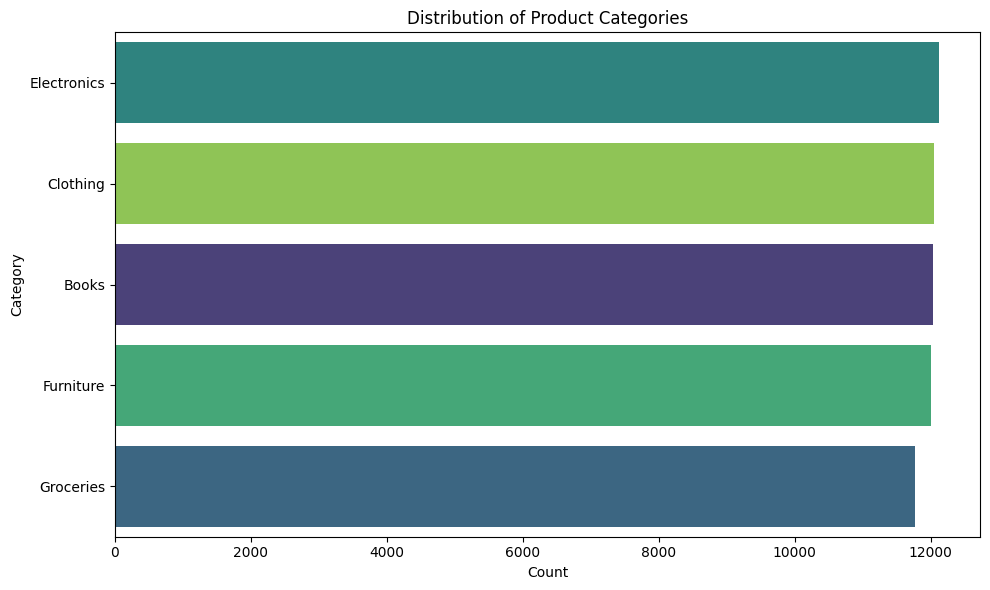

In [14]:
# Distribution of product categories
if 'category' in df.columns:
    plt.figure(figsize=(10, 6))
    # Corrected usage of palette with hue
    sns.countplot(y='category', data=df, order=df['category'].value_counts().index,
                 palette='viridis', hue='category', legend=False)
    plt.title('Distribution of Product Categories')
    plt.xlabel('Count')
    plt.ylabel('Category')
    plt.tight_layout()
    plt.show()

2025-06-02 17:13:42,016 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-02 17:13:42,047 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


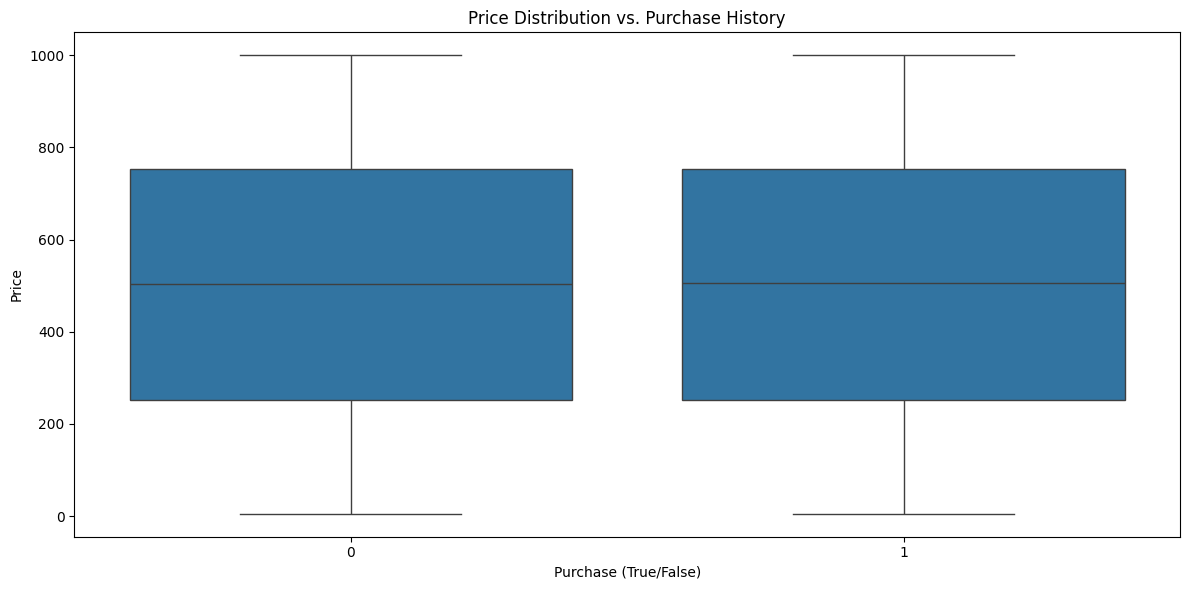

2025-06-02 17:13:42,358 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-02 17:13:42,400 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


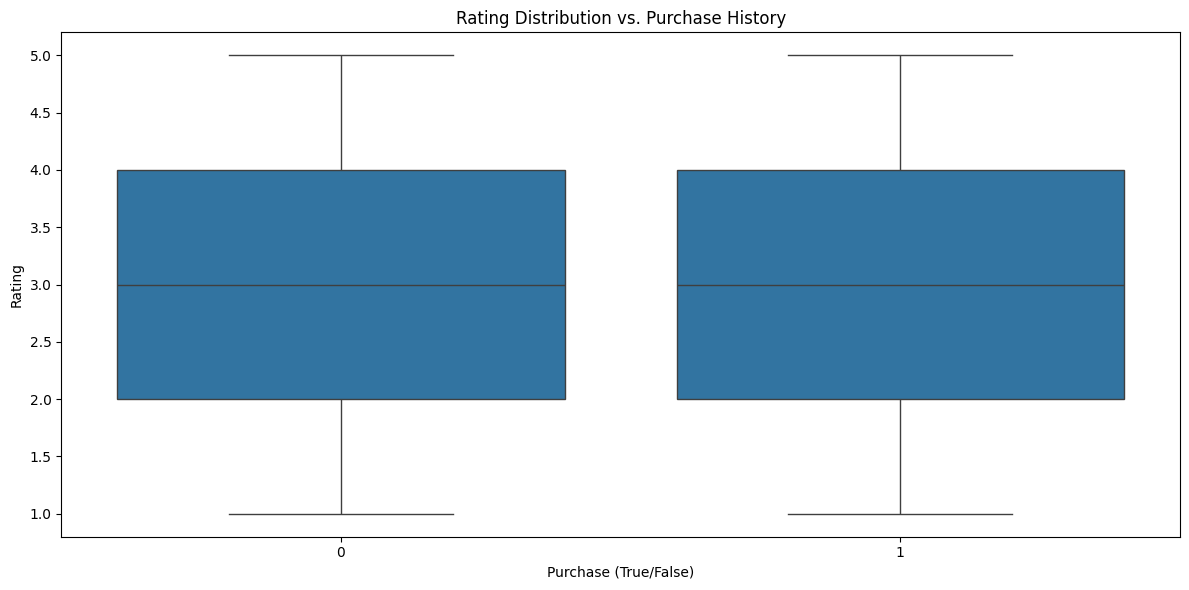

In [15]:
# Relationship between price, rating, and purchase likelihood
plt.figure(figsize=(12, 6))
sns.boxplot(x='purchase_history', y='price', data=df)
plt.title('Price Distribution vs. Purchase History')
plt.xlabel('Purchase (True/False)')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

if 'rating' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='purchase_history', y='rating', data=df)
    plt.title('Rating Distribution vs. Purchase History')
    plt.xlabel('Purchase (True/False)')
    plt.ylabel('Rating')
    plt.tight_layout()
    plt.show()


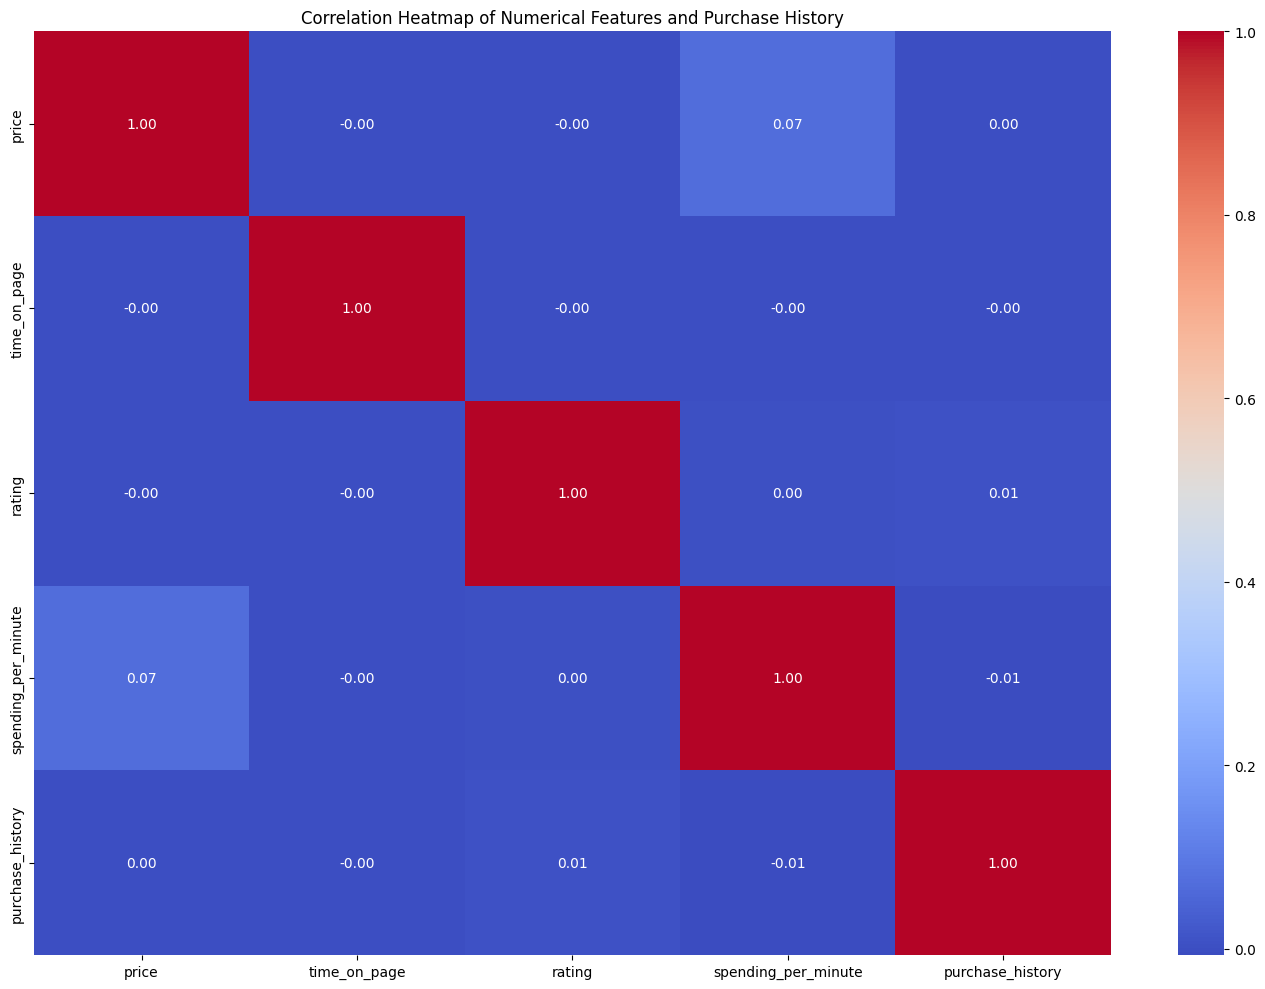

EDA complete. Visualizations displayed.


In [16]:
# Correlation heatmap (after numerical features are imputed and scaled, which happens in pipeline)
# For EDA, let's look at correlations of raw numerical data first
plt.figure(figsize=(14, 10))
sns.heatmap(df[numerical_features + ['purchase_history']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features and Purchase History')
plt.tight_layout()
plt.show()

print("EDA complete. Visualizations displayed.")

# --- Step 4: Train-Test Split --

In [17]:
# Train-Test Split
print("\nStep 4: Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")
print("Data split complete.")


Step 4: Splitting data into training and testing sets...
Training set shape: (42000, 51), (42000,)
Testing set shape: (18000, 51), (18000,)
Data split complete.


# --- Step 5: Choose and Train Models ---

In [18]:
# Define models to train
models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear'),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting (XGBoost)': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

trained_models = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    # Create a pipeline that first preprocesses, then trains the model
    full_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', model)])
    full_pipeline.fit(X_train, y_train)
    trained_models[name] = full_pipeline
    print(f"{name} trained successfully.")

print("\nAll models trained.")


Training Logistic Regression...
Logistic Regression trained successfully.

Training Decision Tree...
Decision Tree trained successfully.

Training Random Forest...
Random Forest trained successfully.

Training Gradient Boosting (XGBoost)...
Gradient Boosting (XGBoost) trained successfully.

All models trained.


# --- Step 6: Model Evaluation ---


Evaluating Logistic Regression:
  Accuracy: 0.4993
  Precision: 0.5006
  Recall: 0.6214
  F1-Score: 0.5545
  ROC-AUC: 0.5007

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.38      0.43      8974
           1       0.50      0.62      0.55      9026

    accuracy                           0.50     18000
   macro avg       0.50      0.50      0.49     18000
weighted avg       0.50      0.50      0.49     18000



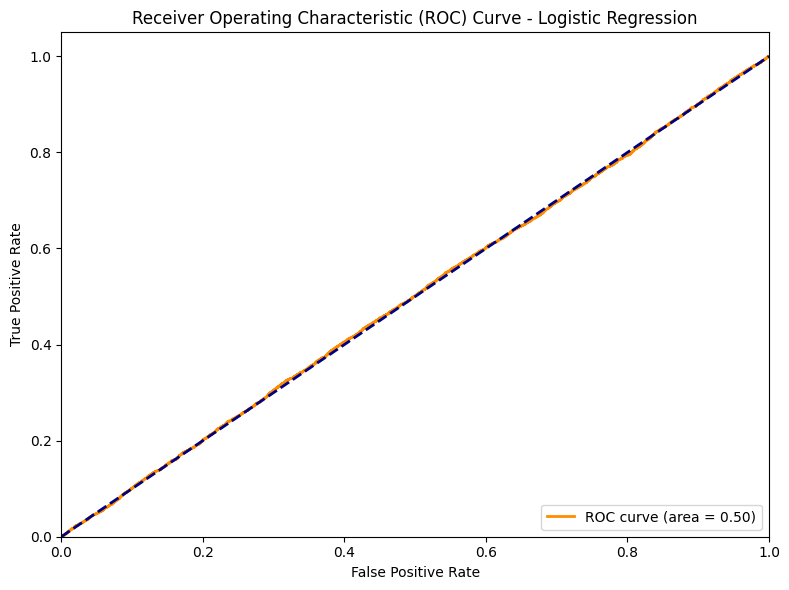


Evaluating Decision Tree:
  Accuracy: 0.4962
  Precision: 0.4976
  Recall: 0.4993
  F1-Score: 0.4985
  ROC-AUC: 0.4962

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.49      0.49      8974
           1       0.50      0.50      0.50      9026

    accuracy                           0.50     18000
   macro avg       0.50      0.50      0.50     18000
weighted avg       0.50      0.50      0.50     18000



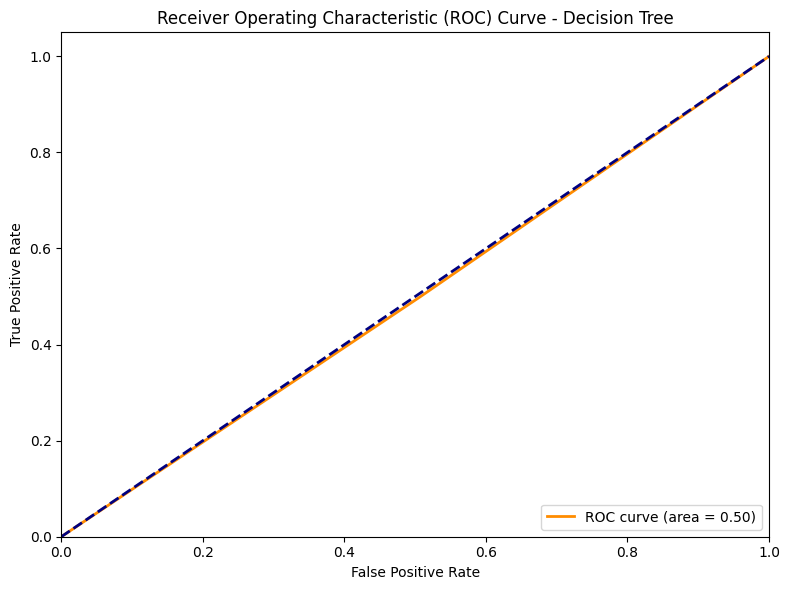


Evaluating Random Forest:
  Accuracy: 0.4988
  Precision: 0.5002
  Recall: 0.4914
  F1-Score: 0.4958
  ROC-AUC: 0.5007

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.51      0.50      8974
           1       0.50      0.49      0.50      9026

    accuracy                           0.50     18000
   macro avg       0.50      0.50      0.50     18000
weighted avg       0.50      0.50      0.50     18000



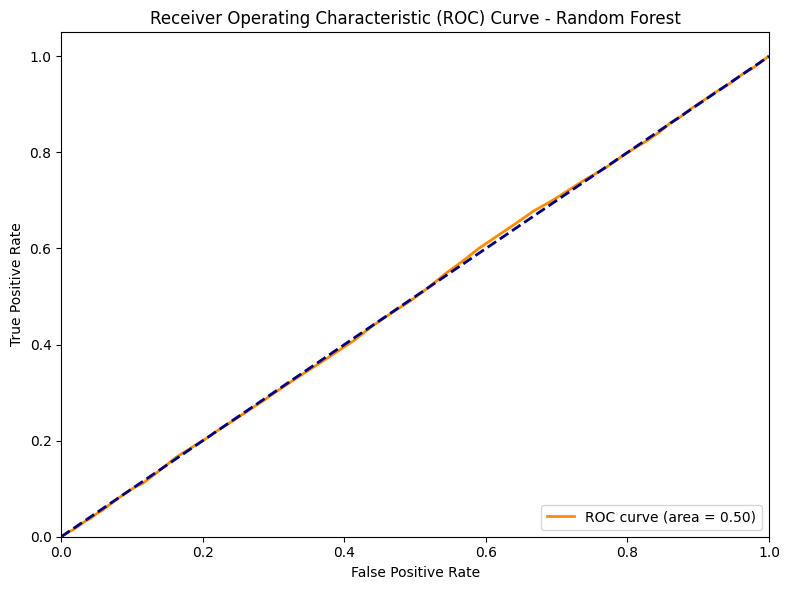


Evaluating Gradient Boosting (XGBoost):
  Accuracy: 0.5015
  Precision: 0.5029
  Recall: 0.5055
  F1-Score: 0.5042
  ROC-AUC: 0.5002

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      8974
           1       0.50      0.51      0.50      9026

    accuracy                           0.50     18000
   macro avg       0.50      0.50      0.50     18000
weighted avg       0.50      0.50      0.50     18000



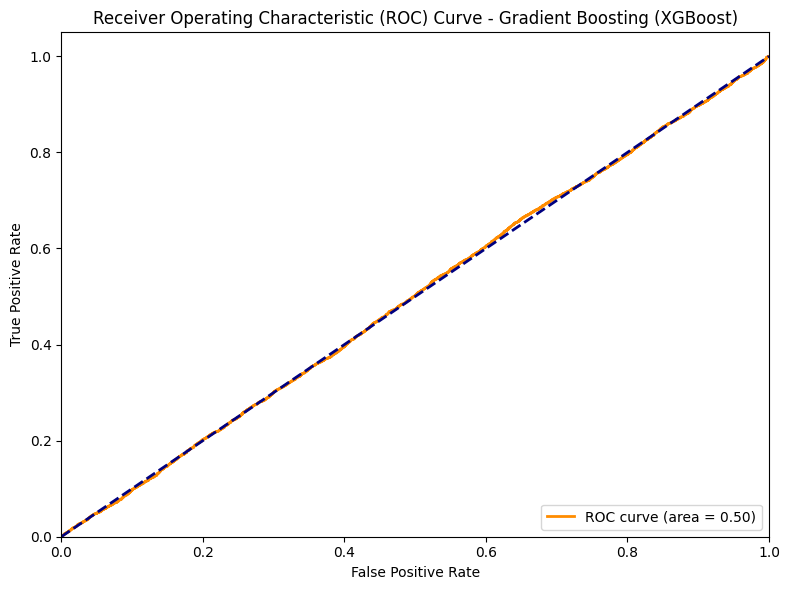


Model evaluation complete.

Best performing model based on ROC-AUC: Logistic Regression (ROC-AUC: 0.5007)


In [19]:
results = {}
best_model_name = None
best_roc_auc = -1

for name, model in trained_models.items():
    print(f"\nEvaluating {name}:")
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] # Probability of positive class

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc_val = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_val:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {name}')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    # Determine the best model based on ROC-AUC
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_model_name = name

print("\nModel evaluation complete.")
print(f"\nBest performing model based on ROC-AUC: {best_model_name} (ROC-AUC: {best_roc_auc:.4f})")

# --- Step 7: Build a Simple Recommendation System ---

In [20]:
# For simplicity, we'll build a content-based recommender based on product category.
# When a user purchases a product, we recommend other popular products from the same category
# that the user hasn't purchased yet.

# Ensure 'product_id' exists for a realistic recommendation system.
# Assuming 'product_id' is available, or we can use DataFrame index as a proxy.
if 'product_id' not in df.columns:
    df['product_id'] = df.index # Use index as product_id if not present
    print("Warning: 'product_id' not found, using DataFrame index as product_id.")

def recommend_products(user_id, num_recommendations=5):
    """
    Recommends products based on a user's purchase history and product categories.
    For demonstration, this function assumes a 'user_id' column exists.
    If not, it will just recommend based on a random purchase.
    """
    print(f"\nGenerating recommendations for user (or based on a sample purchase)...")

    # Get user's purchased products
    user_purchases = df[(df['purchase_history'] == 1)] # Simplified: consider all purchased items
    
    if user_purchases.empty:
        print("No purchases found to base recommendations on. Recommending top popular products overall.")
        # Fallback: Recommend top popular products overall
        top_popular_products = df.sort_values(by='product_popularity', ascending=False).head(num_recommendations)
        return top_popular_products[['product_id', 'category', 'product_popularity', 'rating', 'price']]

    # Select a random purchased product to base recommendations on (for demonstration)
    # In a real system, you'd analyze all user's purchases or their last purchase
    sample_purchase = user_purchases.sample(1).iloc[0]
    purchased_category = sample_purchase['category']
    purchased_product_id = sample_purchase['product_id']

    print(f"  Sample purchased product (ID: {purchased_product_id}, Category: {purchased_category})")

    # Find other products in the same category, sorted by popularity and rating
    category_products = df[
        (df['category'] == purchased_category) &
        (df['product_id'] != purchased_product_id) # Exclude the purchased product itself
    ].sort_values(by=['product_popularity', 'rating'], ascending=[False, False])

    # Filter out products already purchased by the user (if user_id is available and linked to purchases)
    # For this simplified example, we'll just recommend from the category.
    # In a real scenario, you'd need a mapping of user_id to their full purchase history.

    recommendations = category_products.head(num_recommendations)

    if recommendations.empty:
        print(f"  No other products found in category '{purchased_category}' to recommend.")
        print("  Recommending top popular products overall instead.")
        top_popular_products = df.sort_values(by='product_popularity', ascending=False).head(num_recommendations)
        return top_popular_products[['product_id', 'category', 'product_popularity', 'rating', 'price']]
    
    return recommendations[['product_id', 'category', 'product_popularity', 'rating', 'price']]

# Example usage of the recommender (assuming a user_id or just demonstrating with sample purchases)
# Note: For a true multi-user recommendation, you'd need a 'user_id' column and a way to track individual user purchases.
# For this script, we'll simulate by picking a random purchase from the dataset.
print("\n--- Example Recommendations ---")
# If 'user_id' column exists, pick one. Otherwise, just call with a dummy.
if 'user_id' in df.columns:
    sample_user_id = df['user_id'].sample(1).iloc[0]
    recommended_items = recommend_products(sample_user_id, num_recommendations=5)
else:
    print("No 'user_id' column found. Generating recommendations based on a random purchased product.")
    recommended_items = recommend_products(None, num_recommendations=5) # Pass None for user_id

print("\nRecommended Products:")
print(recommended_items)
print("Recommendation system demonstrated.")


--- Example Recommendations ---

Generating recommendations for user (or based on a sample purchase)...
  Sample purchased product (ID: 2446, Category: Groceries)

Recommended Products:
       product_id   category  product_popularity  rating   price
3897         1417  Groceries                 1.0       5  972.13
5526         1500  Groceries                 1.0       5  417.41
22980        2453  Groceries                 1.0       5  295.97
27328        3162  Groceries                 1.0       5  458.27
28532         686  Groceries                 1.0       5  888.35
Recommendation system demonstrated.


# --- save the model---

In [21]:
# --- Step 8: Save the Model ---
print("\nStep 8: Saving the best performing model...")

if best_model_name:
    model_to_save = trained_models[best_model_name]
    # Use .joblib extension for Joblib files (recommended for scikit-learn models)
    filename_joblib = f'{best_model_name.replace(" ", "_").lower()}_purchase_predictor.joblib'
    joblib.dump(model_to_save, filename_joblib)
    print(f"Model '{best_model_name}' saved as '{filename_joblib}' using joblib.")
    print(f"You can load this model in Jupyter Notebook using: model = joblib.load('{filename_joblib}')")

    # Optionally, save using pickle (generally slower/larger for large models with numpy arrays)
    filename_pickle = f'{best_model_name.replace(" ", "_").lower()}_purchase_predictor.pkl'
    with open(filename_pickle, 'wb') as f:
        pickle.dump(model_to_save, f)
    print(f"Model '{best_model_name}' also saved as '{filename_pickle}' using pickle.")
    print(f"You can load this model in Jupyter Notebook using: with open('{filename_pickle}', 'rb') as f: model = pickle.load(f)")



Step 8: Saving the best performing model...
Model 'Logistic Regression' saved as 'logistic_regression_purchase_predictor.joblib' using joblib.
You can load this model in Jupyter Notebook using: model = joblib.load('logistic_regression_purchase_predictor.joblib')
Model 'Logistic Regression' also saved as 'logistic_regression_purchase_predictor.pkl' using pickle.
You can load this model in Jupyter Notebook using: with open('logistic_regression_purchase_predictor.pkl', 'rb') as f: model = pickle.load(f)
